In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sharansmenon_inat2021birds_path = kagglehub.dataset_download('sharansmenon/inat2021birds')

print('Data source import complete.')


100%|██████████| 5.11G/5.11G [04:23<00:00, 20.8MB/s]

Extracting files...


Data source import complete.


In [ ]:
# !pip install -U torch torchvision

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [ ]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu102', '1.10.1+cu102')

('0.20.1+cu121', '2.5.1+cu121')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import os
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=eaa563365a3b9db3a449f52d5478a62f6b2c56b8fc79d1b02a0e97c48dc47dc2
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
# importing cam utilities
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Block 1: Import necessary libraries
import os
from collections import defaultdict

# Dataset Path
dataset_path = sharansmenon_inat2021birds_path

# Extract family from directory names
family_to_species = defaultdict(list)
species_to_family = {}

# Use os.walk to explore the entire directory structure
for root, dirs, files in os.walk(dataset_path):
    for subdir in dirs:
        subdir_path = os.path.join(root, subdir)
        print(f"Processing: {subdir_path}")

        # Split the folder name
        parts = subdir.split('_')

        # Ensure the folder name has enough parts
        if len(parts) > 4:  # Adjust based on actual structure
            family = parts[4]  # Assuming the family is the 5th part
            family_to_species[family].append(subdir)
            species_to_family[subdir] = family
        else:
            print(f"Skipping: {subdir} (Not enough parts in name)")

Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train
Skipping: bird_train (Not enough parts in name)
Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03418_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_glaucoides
Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/04410_Animalia_Chordata_Aves_Pelecaniformes_Threskiornithidae_Theristicus_caudatus
Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/04248_Animalia_Chordata_Aves_Passeriformes_Thraupidae_Tiaris_olivaceus
Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03800_Animalia_Chordata_Aves_Passeriformes_Estrildidae_Lonchura_punctulata
Processing: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03818_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Euphonia_elegantissima
Processing: /roo

In [ ]:
# Block 2: Transformations and Dataset loading
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for pretrained model input
    transforms.ToTensor(),
])

# Load data
dataset = ImageFolder(dataset_path, transform=transform)

# Remap labels to families
family_labels = []
for path, _ in dataset.imgs:
    species_dir = os.path.basename(os.path.dirname(path))
    if species_dir in species_to_family:
        family_labels.append(species_to_family[species_dir])
    else:
        print(f"Warning: Missing family for species {species_dir}")

# Map family labels to indices
unique_families = list(set(family_labels))
family_to_idx = {family: idx for idx, family in enumerate(unique_families)}

# Update dataset with family labels
dataset.class_to_idx = family_to_idx
dataset.targets = [family_to_idx[label] for label in family_labels]

In [ ]:
print(f"Total families: {len(unique_families)}")
print(f"Total species mapped: {len(family_labels)}")


Total families: 32
Total species mapped: 74300


In [ ]:
for family, species_list in list(family_to_species.items())[:5]:
    print(f"Family: {family}, Species: {species_list[:3]}")


Family: Charadriiformes, Species: ['03418_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_glaucoides', '03422_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_marinus', '03478_Animalia_Chordata_Aves_Charadriiformes_Scolopacidae_Limosa_limosa']
Family: Pelecaniformes, Species: ['04410_Animalia_Chordata_Aves_Pelecaniformes_Threskiornithidae_Theristicus_caudatus', '04404_Animalia_Chordata_Aves_Pelecaniformes_Threskiornithidae_Platalea_flavipes', '04395_Animalia_Chordata_Aves_Pelecaniformes_Pelecanidae_Pelecanus_philippensis']
Family: Passeriformes, Species: ['04248_Animalia_Chordata_Aves_Passeriformes_Thraupidae_Tiaris_olivaceus', '03800_Animalia_Chordata_Aves_Passeriformes_Estrildidae_Lonchura_punctulata', '03818_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Euphonia_elegantissima']
Family: Psittaciformes, Species: ['04505_Animalia_Chordata_Aves_Psittaciformes_Psittacidae_Amazona_viridigenalis', '04522_Animalia_Chordata_Aves_Psittaciformes_Psittaculidae_Alisterus_scapularis'

In [ ]:
from collections import Counter
family_distribution = Counter(dataset.targets)
print(family_distribution)


Counter({26: 33900, 28: 8200, 30: 4600, 10: 3800, 14: 3050, 16: 2650, 18: 2200, 15: 2050, 25: 1800, 24: 1550, 20: 1450, 27: 1450, 11: 1250, 19: 1150, 31: 950, 5: 650, 7: 650, 21: 500, 23: 450, 3: 400, 1: 350, 9: 300, 0: 200, 22: 200, 8: 200, 6: 50, 2: 50, 17: 50, 29: 50, 12: 50, 4: 50, 13: 50})


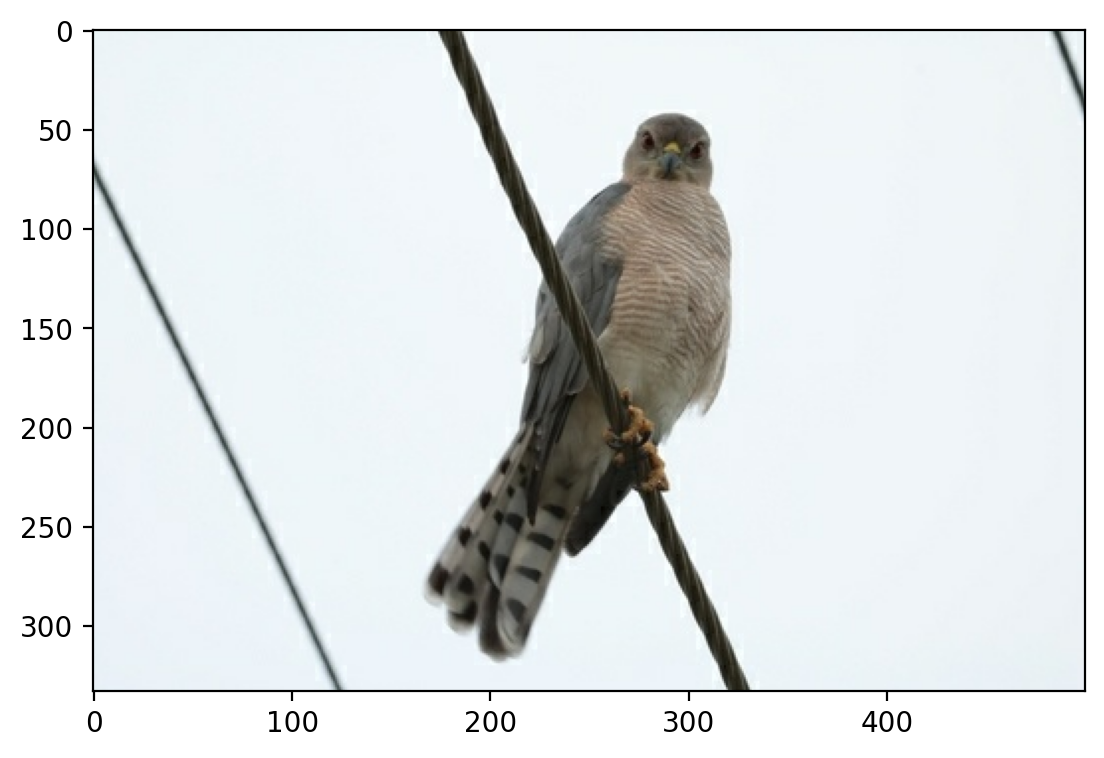

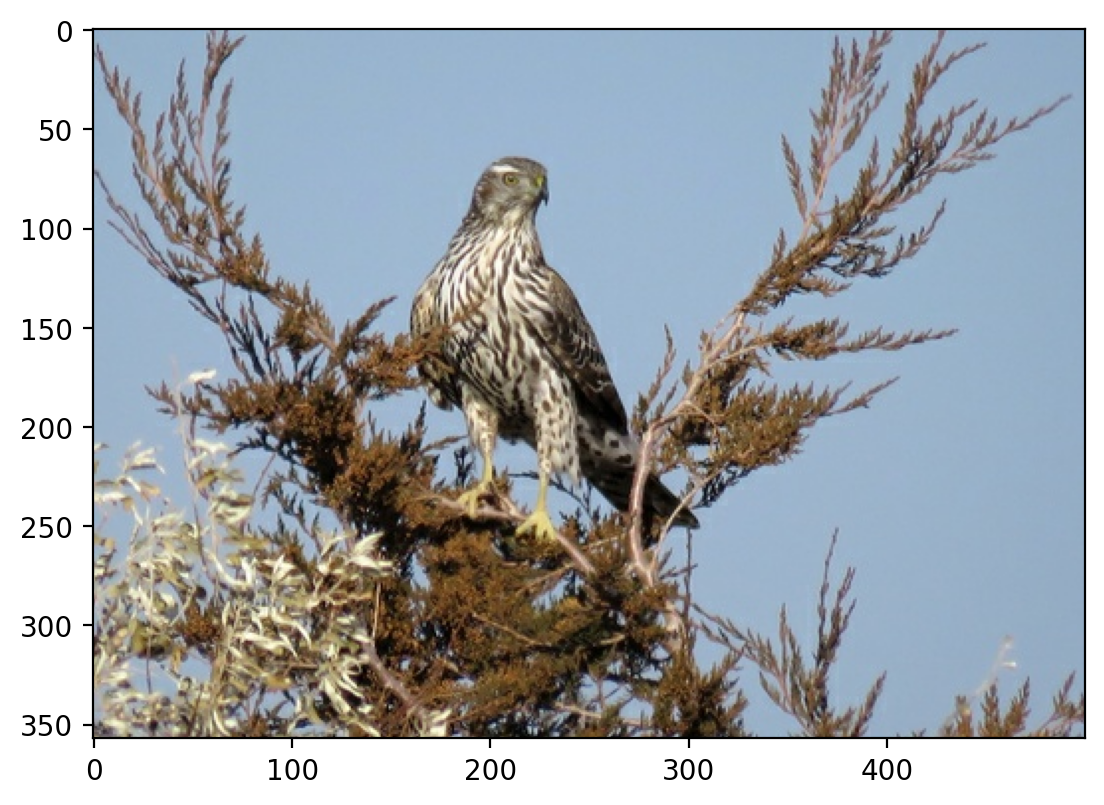

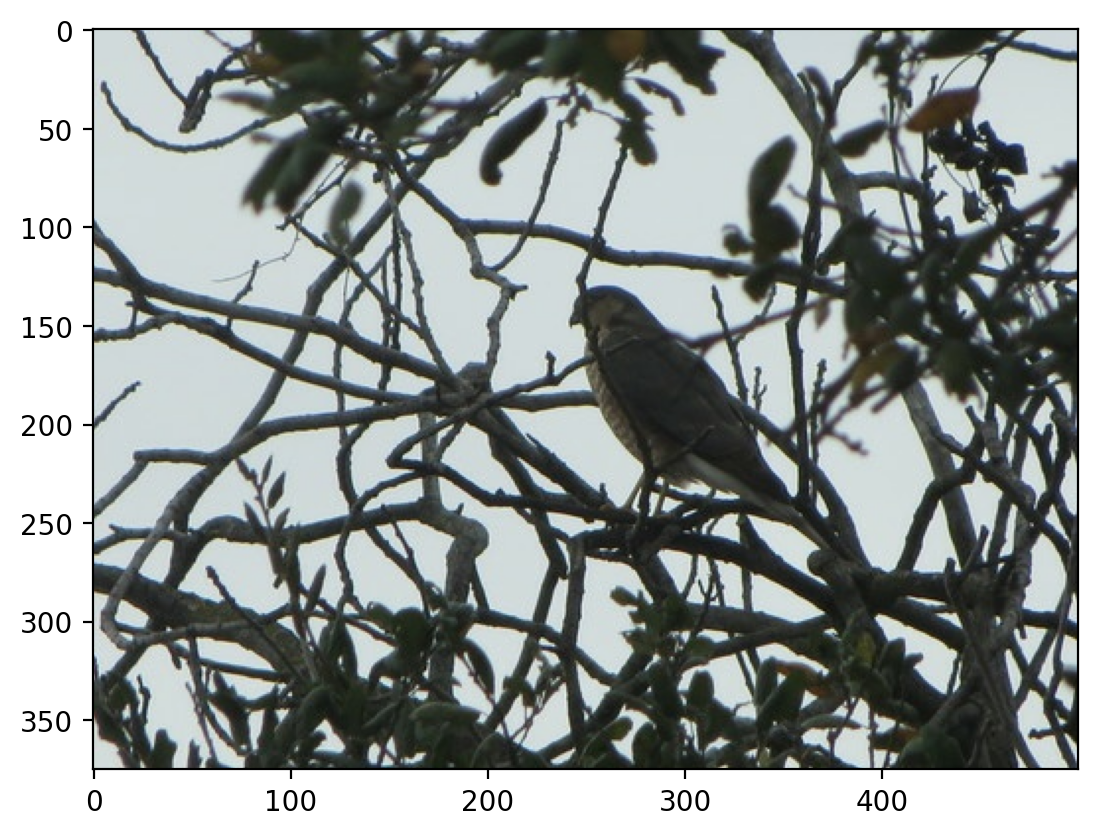

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

sample_images = [dataset.imgs[i][0] for i in [0, 100, 200]]
for img_path in sample_images:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()


In [66]:
# Block 3: DataLoader splits and Model definition
import torch
from torch.utils.data import DataLoader
import timm
from timm.loss import LabelSmoothingCrossEntropy
from sklearn.model_selection import train_test_split
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

# Get all image paths and corresponding targets
all_image_paths = [img[0] for img in dataset.imgs]
all_targets = dataset.targets

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_targets, test_size=0.2, stratify=all_targets, random_state=42
)

# Create a custom dataset for train and validation splits
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = default_loader(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create train and validation datasets
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Model
model = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(unique_families))

In [67]:
# Block 4: Loss and Optimizer
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Block 5: Training Loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    import time
    import copy
    from tqdm import tqdm

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

    dataset_sizes = {
        'train': len(train_loader.dataset),
        'val': len(val_loader.dataset)
    }

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [63]:
train_paths = {dataset.imgs[i][0] for i in range(len(train_dataset))}
val_paths = {dataset.imgs[i][0] for i in range(len(val_dataset))}

# Check for intersection
overlapping_paths = train_paths.intersection(val_paths)
assert not overlapping_paths, f"Overlap detected in file paths: {overlapping_paths}"
print("No overlap in file paths!")


Family-to-Index Mapping:
Family: Gaviiformes, Index: 0
Family: Bucerotiformes, Index: 1
Family: Coliiformes, Index: 2
Family: Trogoniformes, Index: 3
Family: Otidiformes, Index: 4
Family: Cuculiformes, Index: 5
Family: Casuariiformes, Index: 6
Family: Podicipediformes, Index: 7
Family: Sphenisciformes, Index: 8
Family: Cathartiformes, Index: 9
Family: Accipitriformes, Index: 10
Family: Suliformes, Index: 11
Family: Opisthocomiformes, Index: 12
Family: Struthioniformes, Index: 13
Family: Pelecaniformes, Index: 14
Family: Psittaciformes, Index: 15
Family: Piciformes, Index: 16
Family: Galbuliformes, Index: 17
Family: Caprimulgiformes, Index: 18
Family: Strigiformes, Index: 19
Family: Galliformes, Index: 20
Family: Ciconiiformes, Index: 21
Family: Phoenicopteriformes, Index: 22
Family: Procellariiformes, Index: 23
Family: Coraciiformes, Index: 24
Family: Columbiformes, Index: 25
Family: Passeriformes, Index: 26
Family: Gruiformes, Index: 27
Family: Charadriiformes, Index: 28
Family: Musop

In [64]:
for idx, (path, label) in enumerate(zip(dataset.imgs, dataset.targets)):
    species_dir = os.path.basename(os.path.dirname(path[0]))
    family = species_to_family.get(species_dir, "Unknown")
    assigned_index = label
    actual_family = unique_families[assigned_index]

    print(f"Image: {path[0]}, Assigned Family Index: {assigned_index}, Family: {actual_family}")

    # Stop early for debugging
    if idx > 20:
        break


Image: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius/013fe827-0330-4248-8c10-28dd58c679a2.jpg, Assigned Family Index: 10, Family: Accipitriformes
Image: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius/078236e4-98ae-4447-a3f4-c6322d3d7508.jpg, Assigned Family Index: 10, Family: Accipitriformes
Image: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius/12e4fe94-e650-4cf2-8bc7-2adfca4a21ab.jpg, Assigned Family Index: 10, Family: Accipitriformes
Image: /root/.cache/kagglehub/datasets/sharansmenon/inat2021birds/versions/1/bird_train/03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius/15a34371-3ad0-4d34-aa6c-ecfb19f6299a.jpg, Assigned Family Index: 10, 

In [70]:
# Check for overlap in file paths
train_paths_set = set(train_paths)
val_paths_set = set(val_paths)

overlapping_paths = train_paths_set.intersection(val_paths_set)
assert not overlapping_paths, f"Overlap detected in file paths: {overlapping_paths}"
print("No overlap in file paths!")

# Check for label distribution
print("Unique Train Labels:", set(train_labels))
print("Unique Validation Labels:", set(val_labels))

# Expected: Train and Validation labels can overlap because they belong to the same class distribution


No overlap in file paths!
Unique Train Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Unique Validation Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}


In [71]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 1858/1858 [08:23<00:00,  3.69it/s]


train Loss: 1.8102 Acc: 0.6202


100%|██████████| 465/465 [01:37<00:00,  4.77it/s]


val Loss: 1.7176 Acc: 0.6474

Epoch 1/4
----------


100%|██████████| 1858/1858 [08:20<00:00,  3.71it/s]


train Loss: 1.6749 Acc: 0.6523


100%|██████████| 465/465 [01:33<00:00,  5.00it/s]


val Loss: 1.6645 Acc: 0.6630

Epoch 2/4
----------


100%|██████████| 1858/1858 [08:21<00:00,  3.70it/s]


train Loss: 1.6334 Acc: 0.6641


100%|██████████| 465/465 [01:35<00:00,  4.88it/s]


val Loss: 1.6582 Acc: 0.6620

Epoch 3/4
----------


100%|██████████| 1858/1858 [08:18<00:00,  3.73it/s]


train Loss: 1.6086 Acc: 0.6700


100%|██████████| 465/465 [01:33<00:00,  5.00it/s]


val Loss: 1.6395 Acc: 0.6641

Epoch 4/4
----------


100%|██████████| 1858/1858 [08:18<00:00,  3.72it/s]


train Loss: 1.5912 Acc: 0.6742


100%|██████████| 465/465 [01:37<00:00,  4.76it/s]

val Loss: 1.6479 Acc: 0.6645

Training complete in 49m 41s
Best val Acc: 0.664468


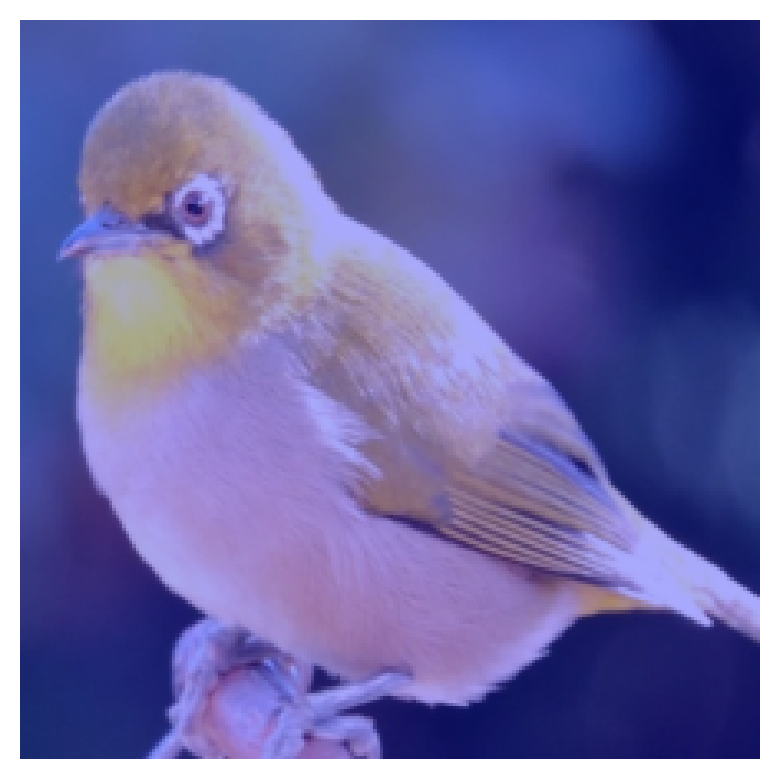

In [132]:
# Ensure the model is in evaluation mode
model.eval()
n = 3

# Get a different data sample from the validation loader
# Skip the first few batches to get a different image
val_iter = iter(val_loader)
for _ in range(n):  # Skip 'n' batches
    data, target = next(val_iter)

data = data[:1].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Specify the target layer (adjust based on model architecture)
target_layer = model.blocks[-1][-1].conv_pwl

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Specify the class index (e.g., the first class in this example)
class_index = target[0].item()
targets = [ClassifierOutputTarget(class_index)]

# Generate the CAM
grayscale_cam = cam(input_tensor=data, targets=targets)
grayscale_cam = grayscale_cam[0, :]  # Select the first batch element

# Overlay CAM on the input image
input_image = data[0].permute(1, 2, 0).cpu().detach().numpy()  # Adjust if necessary
input_image_normalized = (input_image - input_image.min()) / (input_image.max() - input_image.min())
cam_image = show_cam_on_image(input_image_normalized, grayscale_cam, use_rgb=True)

# Display the CAM
plt.imshow(cam_image)
plt.axis('off')
plt.show()


In [ ]:
# 2.1 old one


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch

from torchvision.datasets import ImageFolder

def get_classes(data_dir):
    dataset = CustomImageFolder(data_dir + "/bird_train")
    return dataset.classes  # Use the 'classes' attribute directly


class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Use original folder names as class names
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Store the original class names for later use
        self.original_classes = classes
        return classes, class_to_idx

    def __getitem__(self, index):
        # Default behavior: get image tensor and original integer label
        sample, original_target = super().__getitem__(index)
        # Map original target to its corresponding class name if needed
        original_class_name = self.original_classes[original_target]
        return sample, original_target  # Return processed target directly if no mapping is required




def get_data_loaders(data_dir, batch_size):
    # Transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.2, value='random')
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load dataset
    all_data = CustomImageFolder(data_dir + "/bird_train", transform=train_transform)
    train_data_len = int(len(all_data) * 0.78)
    valid_data_len = int((len(all_data) - train_data_len) / 2)
    test_data_len = len(all_data) - train_data_len - valid_data_len

    train_data, val_data, test_data = random_split(
        all_data, [train_data_len, valid_data_len, test_data_len]
    )

    # Apply different transforms to validation and test datasets
    val_data.dataset.transform = eval_transform
    test_data.dataset.transform = eval_transform

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len







In [ ]:
# new one, based on family, 2.2

import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch


def get_families(data_dir):
    dataset = CustomImageFolder(data_dir + "/bird_train")
    return dataset.classes  # This will return families instead of species


class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Extract the "Family" from folder names
        classes = sorted(
            set(entry.name.split("_")[0] for entry in os.scandir(directory) if entry.is_dir())
        )
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Store the "Family" class names for later use
        self.original_classes = classes
        return classes, class_to_idx

    def __getitem__(self, index):
        # Default behavior: get image tensor and original integer label
        sample, original_target = super().__getitem__(index)
        # Map original target to its corresponding "Family" name if needed
        original_class_name = self.original_classes[original_target]
        return sample, original_target  # Return processed target directly if no mapping is required


def get_data_loaders(data_dir, batch_size):
    # Transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.2, value='random')
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load dataset with "Family" classification
    all_data = CustomImageFolder(data_dir + "/bird_train", transform=train_transform)
    train_data_len = int(len(all_data) * 0.78)
    valid_data_len = int((len(all_data) - train_data_len) / 2)
    test_data_len = len(all_data) - train_data_len - valid_data_len

    train_data, val_data, test_data = random_split(
        all_data, [train_data_len, valid_data_len, test_data_len]
    )

    # Apply different transforms to validation and test datasets
    val_data.dataset.transform = eval_transform
    test_data.dataset.transform = eval_transform

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len


In [ ]:
dataset_path = sharansmenon_inat2021birds_path

# Call get_data_loaders once to get all loaders and dataset lengths
train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len = get_data_loaders(dataset_path, 128)

# Get classes (families)
classes = get_families(dataset_path)


FileNotFoundError: Found no valid file for the classes 03111, 03112, 03113, 03114, 03115, 03116, 03117, 03118, 03119, 03120, 03121, 03122, 03123, 03124, 03125, 03126, 03127, 03128, 03129, 03130, 03131, 03132, 03133, 03134, 03135, 03136, 03137, 03138, 03139, 03140, 03141, 03142, 03143, 03144, 03145, 03146, 03147, 03148, 03149, 03150, 03151, 03152, 03153, 03154, 03155, 03156, 03157, 03158, 03159, 03160, 03161, 03162, 03163, 03164, 03165, 03166, 03167, 03168, 03169, 03170, 03171, 03172, 03173, 03174, 03175, 03176, 03177, 03178, 03179, 03180, 03181, 03182, 03183, 03184, 03185, 03186, 03187, 03188, 03189, 03190, 03191, 03192, 03193, 03194, 03195, 03196, 03197, 03198, 03199, 03200, 03201, 03202, 03203, 03204, 03205, 03206, 03207, 03208, 03209, 03210, 03211, 03212, 03213, 03214, 03215, 03216, 03217, 03218, 03219, 03220, 03221, 03222, 03223, 03224, 03225, 03226, 03227, 03228, 03229, 03230, 03231, 03232, 03233, 03234, 03235, 03236, 03237, 03238, 03239, 03240, 03241, 03242, 03243, 03244, 03245, 03246, 03247, 03248, 03249, 03250, 03251, 03252, 03253, 03254, 03255, 03256, 03257, 03258, 03259, 03260, 03261, 03262, 03263, 03264, 03265, 03266, 03267, 03268, 03269, 03270, 03271, 03272, 03273, 03274, 03275, 03276, 03277, 03278, 03279, 03280, 03281, 03282, 03283, 03284, 03285, 03286, 03287, 03288, 03289, 03290, 03291, 03292, 03293, 03294, 03295, 03296, 03297, 03298, 03299, 03300, 03301, 03302, 03303, 03304, 03305, 03306, 03307, 03308, 03309, 03310, 03311, 03312, 03313, 03314, 03315, 03316, 03317, 03318, 03319, 03320, 03321, 03322, 03323, 03324, 03325, 03326, 03327, 03328, 03329, 03330, 03331, 03332, 03333, 03334, 03335, 03336, 03337, 03338, 03339, 03340, 03341, 03342, 03343, 03344, 03345, 03346, 03347, 03348, 03349, 03350, 03351, 03352, 03353, 03354, 03355, 03356, 03357, 03358, 03359, 03360, 03361, 03362, 03363, 03364, 03365, 03366, 03367, 03368, 03369, 03370, 03371, 03372, 03373, 03374, 03375, 03376, 03377, 03378, 03379, 03380, 03381, 03382, 03383, 03384, 03385, 03386, 03387, 03388, 03389, 03390, 03391, 03392, 03393, 03394, 03395, 03396, 03397, 03398, 03399, 03400, 03401, 03402, 03403, 03404, 03405, 03406, 03407, 03408, 03409, 03410, 03411, 03412, 03413, 03414, 03415, 03416, 03417, 03418, 03419, 03420, 03421, 03422, 03423, 03424, 03425, 03426, 03427, 03428, 03429, 03430, 03431, 03432, 03433, 03434, 03435, 03436, 03437, 03438, 03439, 03440, 03441, 03442, 03443, 03444, 03445, 03446, 03447, 03448, 03449, 03450, 03451, 03452, 03453, 03454, 03455, 03456, 03457, 03458, 03459, 03460, 03461, 03462, 03463, 03464, 03465, 03466, 03467, 03468, 03469, 03470, 03471, 03472, 03473, 03474, 03475, 03476, 03477, 03478, 03479, 03480, 03481, 03482, 03483, 03484, 03485, 03486, 03487, 03488, 03489, 03490, 03491, 03492, 03493, 03494, 03495, 03496, 03497, 03498, 03499, 03500, 03501, 03502, 03503, 03504, 03505, 03506, 03507, 03508, 03509, 03510, 03511, 03512, 03513, 03514, 03515, 03516, 03517, 03518, 03519, 03520, 03521, 03522, 03523, 03524, 03525, 03526, 03527, 03528, 03529, 03530, 03531, 03532, 03533, 03534, 03535, 03536, 03537, 03538, 03539, 03540, 03541, 03542, 03543, 03544, 03545, 03546, 03547, 03548, 03549, 03550, 03551, 03552, 03553, 03554, 03555, 03556, 03557, 03558, 03559, 03560, 03561, 03562, 03563, 03564, 03565, 03566, 03567, 03568, 03569, 03570, 03571, 03572, 03573, 03574, 03575, 03576, 03577, 03578, 03579, 03580, 03581, 03582, 03583, 03584, 03585, 03586, 03587, 03588, 03589, 03590, 03591, 03592, 03593, 03594, 03595, 03596, 03597, 03598, 03599, 03600, 03601, 03602, 03603, 03604, 03605, 03606, 03607, 03608, 03609, 03610, 03611, 03612, 03613, 03614, 03615, 03616, 03617, 03618, 03619, 03620, 03621, 03622, 03623, 03624, 03625, 03626, 03627, 03628, 03629, 03630, 03631, 03632, 03633, 03634, 03635, 03636, 03637, 03638, 03639, 03640, 03641, 03642, 03643, 03644, 03645, 03646, 03647, 03648, 03649, 03650, 03651, 03652, 03653, 03654, 03655, 03656, 03657, 03658, 03659, 03660, 03661, 03662, 03663, 03664, 03665, 03666, 03667, 03668, 03669, 03670, 03671, 03672, 03673, 03674, 03675, 03676, 03677, 03678, 03679, 03680, 03681, 03682, 03683, 03684, 03685, 03686, 03687, 03688, 03689, 03690, 03691, 03692, 03693, 03694, 03695, 03696, 03697, 03698, 03699, 03700, 03701, 03702, 03703, 03704, 03705, 03706, 03707, 03708, 03709, 03710, 03711, 03712, 03713, 03714, 03715, 03716, 03717, 03718, 03719, 03720, 03721, 03722, 03723, 03724, 03725, 03726, 03727, 03728, 03729, 03730, 03731, 03732, 03733, 03734, 03735, 03736, 03737, 03738, 03739, 03740, 03741, 03742, 03743, 03744, 03745, 03746, 03747, 03748, 03749, 03750, 03751, 03752, 03753, 03754, 03755, 03756, 03757, 03758, 03759, 03760, 03761, 03762, 03763, 03764, 03765, 03766, 03767, 03768, 03769, 03770, 03771, 03772, 03773, 03774, 03775, 03776, 03777, 03778, 03779, 03780, 03781, 03782, 03783, 03784, 03785, 03786, 03787, 03788, 03789, 03790, 03791, 03792, 03793, 03794, 03795, 03796, 03797, 03798, 03799, 03800, 03801, 03802, 03803, 03804, 03805, 03806, 03807, 03808, 03809, 03810, 03811, 03812, 03813, 03814, 03815, 03816, 03817, 03818, 03819, 03820, 03821, 03822, 03823, 03824, 03825, 03826, 03827, 03828, 03829, 03830, 03831, 03832, 03833, 03834, 03835, 03836, 03837, 03838, 03839, 03840, 03841, 03842, 03843, 03844, 03845, 03846, 03847, 03848, 03849, 03850, 03851, 03852, 03853, 03854, 03855, 03856, 03857, 03858, 03859, 03860, 03861, 03862, 03863, 03864, 03865, 03866, 03867, 03868, 03869, 03870, 03871, 03872, 03873, 03874, 03875, 03876, 03877, 03878, 03879, 03880, 03881, 03882, 03883, 03884, 03885, 03886, 03887, 03888, 03889, 03890, 03891, 03892, 03893, 03894, 03895, 03896, 03897, 03898, 03899, 03900, 03901, 03902, 03903, 03904, 03905, 03906, 03907, 03908, 03909, 03910, 03911, 03912, 03913, 03914, 03915, 03916, 03917, 03918, 03919, 03920, 03921, 03922, 03923, 03924, 03925, 03926, 03927, 03928, 03929, 03930, 03931, 03932, 03933, 03934, 03935, 03936, 03937, 03938, 03939, 03940, 03941, 03942, 03943, 03944, 03945, 03946, 03947, 03948, 03949, 03950, 03951, 03952, 03953, 03954, 03955, 03956, 03957, 03958, 03959, 03960, 03961, 03962, 03963, 03964, 03965, 03966, 03967, 03968, 03969, 03970, 03971, 03972, 03973, 03974, 03975, 03976, 03977, 03978, 03979, 03980, 03981, 03982, 03983, 03984, 03985, 03986, 03987, 03988, 03989, 03990, 03991, 03992, 03993, 03994, 03995, 03996, 03997, 03998, 03999, 04000, 04001, 04002, 04003, 04004, 04005, 04006, 04007, 04008, 04009, 04010, 04011, 04012, 04013, 04014, 04015, 04016, 04017, 04018, 04019, 04020, 04021, 04022, 04023, 04024, 04025, 04026, 04027, 04028, 04029, 04030, 04031, 04032, 04033, 04034, 04035, 04036, 04037, 04038, 04039, 04040, 04041, 04042, 04043, 04044, 04045, 04046, 04047, 04048, 04049, 04050, 04051, 04052, 04053, 04054, 04055, 04056, 04057, 04058, 04059, 04060, 04061, 04062, 04063, 04064, 04065, 04066, 04067, 04068, 04069, 04070, 04071, 04072, 04073, 04074, 04075, 04076, 04077, 04078, 04079, 04080, 04081, 04082, 04083, 04084, 04085, 04086, 04087, 04088, 04089, 04090, 04091, 04092, 04093, 04094, 04095, 04096, 04097, 04098, 04099, 04100, 04101, 04102, 04103, 04104, 04105, 04106, 04107, 04108, 04109, 04110, 04111, 04112, 04113, 04114, 04115, 04116, 04117, 04118, 04119, 04120, 04121, 04122, 04123, 04124, 04125, 04126, 04127, 04128, 04129, 04130, 04131, 04132, 04133, 04134, 04135, 04136, 04137, 04138, 04139, 04140, 04141, 04142, 04143, 04144, 04145, 04146, 04147, 04148, 04149, 04150, 04151, 04152, 04153, 04154, 04155, 04156, 04157, 04158, 04159, 04160, 04161, 04162, 04163, 04164, 04165, 04166, 04167, 04168, 04169, 04170, 04171, 04172, 04173, 04174, 04175, 04176, 04177, 04178, 04179, 04180, 04181, 04182, 04183, 04184, 04185, 04186, 04187, 04188, 04189, 04190, 04191, 04192, 04193, 04194, 04195, 04196, 04197, 04198, 04199, 04200, 04201, 04202, 04203, 04204, 04205, 04206, 04207, 04208, 04209, 04210, 04211, 04212, 04213, 04214, 04215, 04216, 04217, 04218, 04219, 04220, 04221, 04222, 04223, 04224, 04225, 04226, 04227, 04228, 04229, 04230, 04231, 04232, 04233, 04234, 04235, 04236, 04237, 04238, 04239, 04240, 04241, 04242, 04243, 04244, 04245, 04246, 04247, 04248, 04249, 04250, 04251, 04252, 04253, 04254, 04255, 04256, 04257, 04258, 04259, 04260, 04261, 04262, 04263, 04264, 04265, 04266, 04267, 04268, 04269, 04270, 04271, 04272, 04273, 04274, 04275, 04276, 04277, 04278, 04279, 04280, 04281, 04282, 04283, 04284, 04285, 04286, 04287, 04288, 04289, 04290, 04291, 04292, 04293, 04294, 04295, 04296, 04297, 04298, 04299, 04300, 04301, 04302, 04303, 04304, 04305, 04306, 04307, 04308, 04309, 04310, 04311, 04312, 04313, 04314, 04315, 04316, 04317, 04318, 04319, 04320, 04321, 04322, 04323, 04324, 04325, 04326, 04327, 04328, 04329, 04330, 04331, 04332, 04333, 04334, 04335, 04336, 04337, 04338, 04339, 04340, 04341, 04342, 04343, 04344, 04345, 04346, 04347, 04348, 04349, 04350, 04351, 04352, 04353, 04354, 04355, 04356, 04357, 04358, 04359, 04360, 04361, 04362, 04363, 04364, 04365, 04366, 04367, 04368, 04369, 04370, 04371, 04372, 04373, 04374, 04375, 04376, 04377, 04378, 04379, 04380, 04381, 04382, 04383, 04384, 04385, 04386, 04387, 04388, 04389, 04390, 04391, 04392, 04393, 04394, 04395, 04396, 04397, 04398, 04399, 04400, 04401, 04402, 04403, 04404, 04405, 04406, 04407, 04408, 04409, 04410, 04411, 04412, 04413, 04414, 04415, 04416, 04417, 04418, 04419, 04420, 04421, 04422, 04423, 04424, 04425, 04426, 04427, 04428, 04429, 04430, 04431, 04432, 04433, 04434, 04435, 04436, 04437, 04438, 04439, 04440, 04441, 04442, 04443, 04444, 04445, 04446, 04447, 04448, 04449, 04450, 04451, 04452, 04453, 04454, 04455, 04456, 04457, 04458, 04459, 04460, 04461, 04462, 04463, 04464, 04465, 04466, 04467, 04468, 04469, 04470, 04471, 04472, 04473, 04474, 04475, 04476, 04477, 04478, 04479, 04480, 04481, 04482, 04483, 04484, 04485, 04486, 04487, 04488, 04489, 04490, 04491, 04492, 04493, 04494, 04495, 04496, 04497, 04498, 04499, 04500, 04501, 04502, 04503, 04504, 04505, 04506, 04507, 04508, 04509, 04510, 04511, 04512, 04513, 04514, 04515, 04516, 04517, 04518, 04519, 04520, 04521, 04522, 04523, 04524, 04525, 04526, 04527, 04528, 04529, 04530, 04531, 04532, 04533, 04534, 04535, 04536, 04537, 04538, 04539, 04540, 04541, 04542, 04543, 04544, 04545, 04546, 04547, 04548, 04549, 04550, 04551, 04552, 04553, 04554, 04555, 04556, 04557, 04558, 04559, 04560, 04561, 04562, 04563, 04564, 04565, 04566, 04567, 04568, 04569, 04570, 04571, 04572, 04573, 04574, 04575, 04576, 04577, 04578, 04579, 04580, 04581, 04582, 04583, 04584, 04585, 04586, 04587, 04588, 04589, 04590, 04591, 04592, 04593, 04594, 04595, 04596. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1858
465


NameError: name 'test_loader' is not defined

In [ ]:
print(train_data_len, test_data_len, valid_data_len)

57954 8173 8173


In [ ]:
def formatText(class_label):
    return " ".join(class_label.split("_")[-1:])

In [ ]:
classes[0]

'03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius'

In [ ]:
labels[0]

NameError: name 'labels' is not defined

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter) # Change dataiter.next() to next(dataiter)
images = images.numpy() # convert images to numpy for display

for i in np.arange(20):
    print((classes[labels[i]]))

03594_Animalia_Chordata_Aves_Falconiformes_Falconidae_Falco_berigora
03866_Animalia_Chordata_Aves_Passeriformes_Icteridae_Agelaioides_badius
03850_Animalia_Chordata_Aves_Passeriformes_Hirundinidae_Hirundo_smithii
03633_Animalia_Chordata_Aves_Galliformes_Phasianidae_Lagopus_lagopus
04551_Animalia_Chordata_Aves_Strigiformes_Strigidae_Glaucidium_brasilianum
04015_Animalia_Chordata_Aves_Passeriformes_Oriolidae_Oriolus_larvatus
03418_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_glaucoides
03275_Animalia_Chordata_Aves_Anseriformes_Anatidae_Tadorna_tadornoides
03502_Animalia_Chordata_Aves_Ciconiiformes_Ciconiidae_Ciconia_ciconia
03182_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Rupornis_magnirostris
04428_Animalia_Chordata_Aves_Piciformes_Picidae_Colaptes_campestris
03488_Animalia_Chordata_Aves_Charadriiformes_Scolopacidae_Tringa_erythropus
03201_Animalia_Chordata_Aves_Anseriformes_Anatidae_Anas_platyrhynchos
03692_Animalia_Chordata_Aves_Passeriformes_Alaudidae_Eremophila_alpe

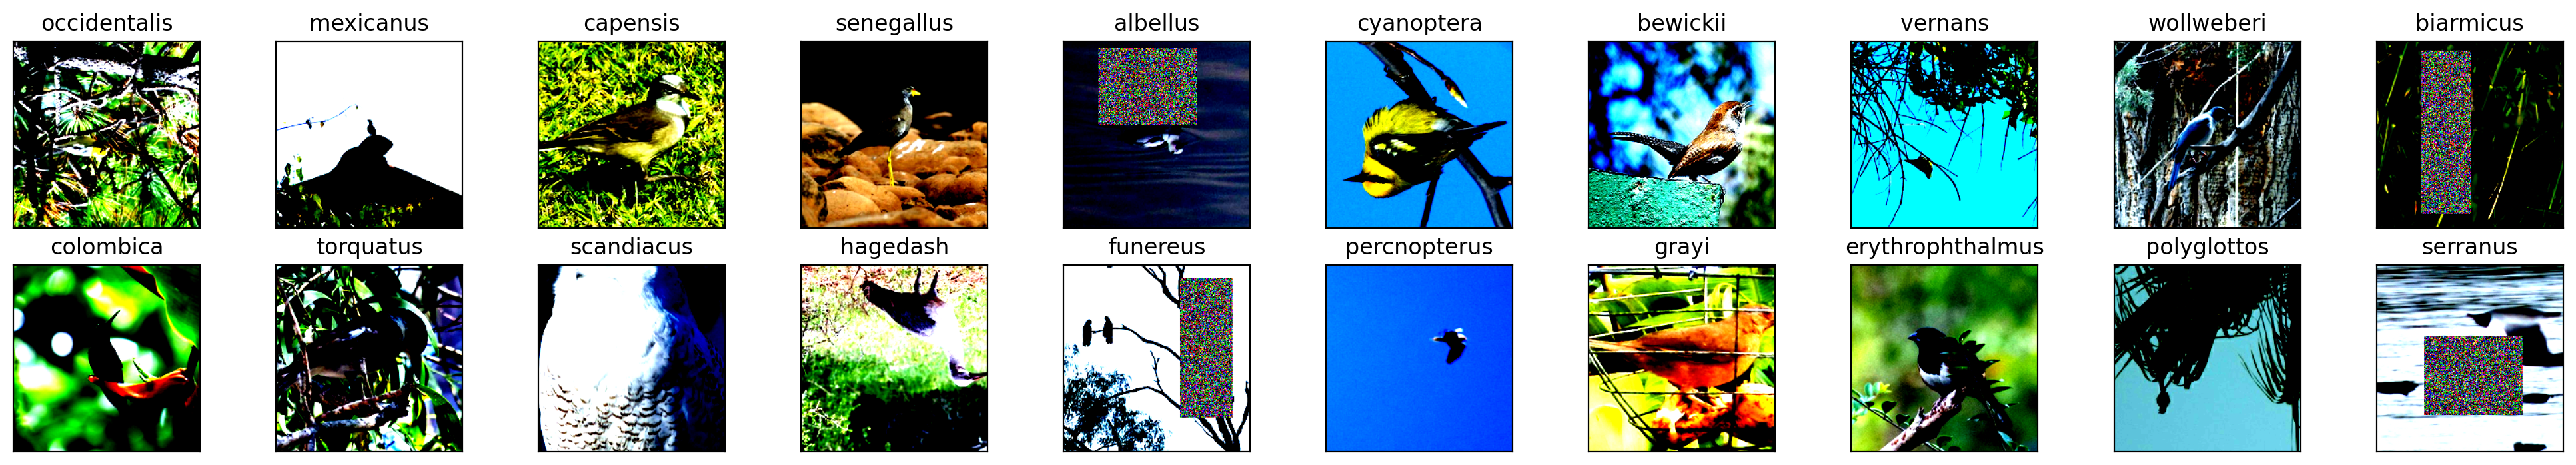

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter) # Change dataiter.next() to next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(formatText(classes[labels[idx]]))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
# model = models.efficientnet_b3(pretrained=True)
model = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
# model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=1486, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
# criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


100%|██████████| 453/453 [06:09<00:00,  1.23it/s]


train Loss: 6.2291 Acc: 0.0465


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


val Loss: 4.8451 Acc: 0.1855

Epoch 1/14
----------


100%|██████████| 453/453 [06:00<00:00,  1.26it/s]


train Loss: 5.1699 Acc: 0.1477


100%|██████████| 64/64 [00:46<00:00,  1.38it/s]


val Loss: 4.1764 Acc: 0.3261

Epoch 2/14
----------


100%|██████████| 453/453 [05:55<00:00,  1.27it/s]


train Loss: 4.6837 Acc: 0.2227


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 3.7883 Acc: 0.4129

Epoch 3/14
----------


100%|██████████| 453/453 [05:53<00:00,  1.28it/s]


train Loss: 4.2921 Acc: 0.2932


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 3.4628 Acc: 0.4976

Epoch 4/14
----------


100%|██████████| 453/453 [05:53<00:00,  1.28it/s]


train Loss: 3.9620 Acc: 0.3605


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


val Loss: 3.2339 Acc: 0.5632

Epoch 5/14
----------


100%|██████████| 453/453 [05:50<00:00,  1.29it/s]


train Loss: 3.6800 Acc: 0.4197


100%|██████████| 64/64 [00:44<00:00,  1.43it/s]


val Loss: 3.0504 Acc: 0.6139

Epoch 6/14
----------


100%|██████████| 453/453 [05:57<00:00,  1.27it/s]


train Loss: 3.3897 Acc: 0.4903


100%|██████████| 64/64 [00:48<00:00,  1.31it/s]


val Loss: 2.8933 Acc: 0.6632

Epoch 7/14
----------


100%|██████████| 453/453 [06:02<00:00,  1.25it/s]


train Loss: 3.1788 Acc: 0.5405


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 2.7837 Acc: 0.7017

Epoch 8/14
----------


100%|██████████| 453/453 [05:54<00:00,  1.28it/s]


train Loss: 2.9816 Acc: 0.5892


100%|██████████| 64/64 [00:45<00:00,  1.42it/s]


val Loss: 2.6816 Acc: 0.7302

Epoch 9/14
----------


100%|██████████| 453/453 [06:01<00:00,  1.25it/s]


train Loss: 2.8227 Acc: 0.6359


100%|██████████| 64/64 [00:45<00:00,  1.39it/s]


val Loss: 2.6126 Acc: 0.7504

Epoch 10/14
----------


100%|██████████| 453/453 [06:01<00:00,  1.25it/s]


train Loss: 2.6822 Acc: 0.6748


100%|██████████| 64/64 [00:45<00:00,  1.42it/s]


val Loss: 2.5739 Acc: 0.7647

Epoch 11/14
----------


100%|██████████| 453/453 [06:03<00:00,  1.24it/s]


train Loss: 2.5791 Acc: 0.7020


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 2.5472 Acc: 0.7727

Epoch 12/14
----------


100%|██████████| 453/453 [06:09<00:00,  1.22it/s]


train Loss: 2.4788 Acc: 0.7308


100%|██████████| 64/64 [00:44<00:00,  1.43it/s]


val Loss: 2.5080 Acc: 0.7872

Epoch 13/14
----------


100%|██████████| 453/453 [05:57<00:00,  1.27it/s]


train Loss: 2.4120 Acc: 0.7529


100%|██████████| 64/64 [00:50<00:00,  1.28it/s]


val Loss: 2.4955 Acc: 0.7900

Epoch 14/14
----------


100%|██████████| 453/453 [06:08<00:00,  1.23it/s]


train Loss: 2.3769 Acc: 0.7640


100%|██████████| 64/64 [00:55<00:00,  1.16it/s]

val Loss: 2.4761 Acc: 0.7952

Training complete in 101m 47s
Best val Acc: 0.795179


In [ ]:
import torch

# Specify the path where the model should be saved
model_save_path = "trained_model.pth"

# Save the model's state_dict (recommended)
torch.save(model_ft.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to trained_model.pth


In [ ]:
num_classes = len(dataloaders['train'].dataset.dataset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 1486


In [ ]:
# Load the model architecture (ensure it matches the saved model)
from torchvision import models

model_ft = models.resnet18(pretrained=False)  # Replace with your model architecture
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)  # Replace num_classes with the number of your classes

# Load the saved weights
model_ft.load_state_dict(torch.load(model_save_path))

# Put the model in evaluation mode for inference
model_ft.eval()

print("Model loaded and ready for inference.")


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv_stem.weight", "blocks.0.0.conv.weight", "blocks.0.0.bn1.weight", "blocks.0.0.bn1.bias", "blocks.0.0.bn1.running_mean", "blocks.0.0.bn1.running_var", "blocks.0.0.bn1.num_batches_tracked", "blocks.1.0.conv_exp.weight", "blocks.1.0.bn1.weight", "blocks.1.0.bn1.bias", "blocks.1.0.bn1.running_mean", "blocks.1.0.bn1.running_var", "blocks.1.0.bn1.num_batches_tracked", "blocks.1.0.conv_pwl.weight", "blocks.1.0.bn2.weight", "blocks.1.0.bn2.bias", "blocks.1.0.bn2.running_mean", "blocks.1.0.bn2.running_var", "blocks.1.0.bn2.num_batches_tracked", "blocks.1.1.conv_exp.weight", "blocks.1.1.bn1.weight", "blocks.1.1.bn1.bias", "blocks.1.1.bn1.running_mean", "blocks.1.1.bn1.running_var", "blocks.1.1.bn1.num_batches_tracked", "blocks.1.1.conv_pwl.weight", "blocks.1.1.bn2.weight", "blocks.1.1.bn2.bias", "blocks.1.1.bn2.running_mean", "blocks.1.1.bn2.running_var", "blocks.1.1.bn2.num_batches_tracked", "blocks.2.0.conv_exp.weight", "blocks.2.0.bn1.weight", "blocks.2.0.bn1.bias", "blocks.2.0.bn1.running_mean", "blocks.2.0.bn1.running_var", "blocks.2.0.bn1.num_batches_tracked", "blocks.2.0.conv_pwl.weight", "blocks.2.0.bn2.weight", "blocks.2.0.bn2.bias", "blocks.2.0.bn2.running_mean", "blocks.2.0.bn2.running_var", "blocks.2.0.bn2.num_batches_tracked", "blocks.2.1.conv_exp.weight", "blocks.2.1.bn1.weight", "blocks.2.1.bn1.bias", "blocks.2.1.bn1.running_mean", "blocks.2.1.bn1.running_var", "blocks.2.1.bn1.num_batches_tracked", "blocks.2.1.conv_pwl.weight", "blocks.2.1.bn2.weight", "blocks.2.1.bn2.bias", "blocks.2.1.bn2.running_mean", "blocks.2.1.bn2.running_var", "blocks.2.1.bn2.num_batches_tracked", "blocks.3.0.conv_pw.weight", "blocks.3.0.bn1.weight", "blocks.3.0.bn1.bias", "blocks.3.0.bn1.running_mean", "blocks.3.0.bn1.running_var", "blocks.3.0.bn1.num_batches_tracked", "blocks.3.0.conv_dw.weight", "blocks.3.0.bn2.weight", "blocks.3.0.bn2.bias", "blocks.3.0.bn2.running_mean", "blocks.3.0.bn2.running_var", "blocks.3.0.bn2.num_batches_tracked", "blocks.3.0.se.conv_reduce.weight", "blocks.3.0.se.conv_reduce.bias", "blocks.3.0.se.conv_expand.weight", "blocks.3.0.se.conv_expand.bias", "blocks.3.0.conv_pwl.weight", "blocks.3.0.bn3.weight", "blocks.3.0.bn3.bias", "blocks.3.0.bn3.running_mean", "blocks.3.0.bn3.running_var", "blocks.3.0.bn3.num_batches_tracked", "blocks.3.1.conv_pw.weight", "blocks.3.1.bn1.weight", "blocks.3.1.bn1.bias", "blocks.3.1.bn1.running_mean", "blocks.3.1.bn1.running_var", "blocks.3.1.bn1.num_batches_tracked", "blocks.3.1.conv_dw.weight", "blocks.3.1.bn2.weight", "blocks.3.1.bn2.bias", "blocks.3.1.bn2.running_mean", "blocks.3.1.bn2.running_var", "blocks.3.1.bn2.num_batches_tracked", "blocks.3.1.se.conv_reduce.weight", "blocks.3.1.se.conv_reduce.bias", "blocks.3.1.se.conv_expand.weight", "blocks.3.1.se.conv_expand.bias", "blocks.3.1.conv_pwl.weight", "blocks.3.1.bn3.weight", "blocks.3.1.bn3.bias", "blocks.3.1.bn3.running_mean", "blocks.3.1.bn3.running_var", "blocks.3.1.bn3.num_batches_tracked", "blocks.3.2.conv_pw.weight", "blocks.3.2.bn1.weight", "blocks.3.2.bn1.bias", "blocks.3.2.bn1.running_mean", "blocks.3.2.bn1.running_var", "blocks.3.2.bn1.num_batches_tracked", "blocks.3.2.conv_dw.weight", "blocks.3.2.bn2.weight", "blocks.3.2.bn2.bias", "blocks.3.2.bn2.running_mean", "blocks.3.2.bn2.running_var", "blocks.3.2.bn2.num_batches_tracked", "blocks.3.2.se.conv_reduce.weight", "blocks.3.2.se.conv_reduce.bias", "blocks.3.2.se.conv_expand.weight", "blocks.3.2.se.conv_expand.bias", "blocks.3.2.conv_pwl.weight", "blocks.3.2.bn3.weight", "blocks.3.2.bn3.bias", "blocks.3.2.bn3.running_mean", "blocks.3.2.bn3.running_var", "blocks.3.2.bn3.num_batches_tracked", "blocks.4.0.conv_pw.weight", "blocks.4.0.bn1.weight", "blocks.4.0.bn1.bias", "blocks.4.0.bn1.running_mean", "blocks.4.0.bn1.running_var", "blocks.4.0.bn1.num_batches_tracked", "blocks.4.0.conv_dw.weight", "blocks.4.0.bn2.weight", "blocks.4.0.bn2.bias", "blocks.4.0.bn2.running_mean", "blocks.4.0.bn2.running_var", "blocks.4.0.bn2.num_batches_tracked", "blocks.4.0.se.conv_reduce.weight", "blocks.4.0.se.conv_reduce.bias", "blocks.4.0.se.conv_expand.weight", "blocks.4.0.se.conv_expand.bias", "blocks.4.0.conv_pwl.weight", "blocks.4.0.bn3.weight", "blocks.4.0.bn3.bias", "blocks.4.0.bn3.running_mean", "blocks.4.0.bn3.running_var", "blocks.4.0.bn3.num_batches_tracked", "blocks.4.1.conv_pw.weight", "blocks.4.1.bn1.weight", "blocks.4.1.bn1.bias", "blocks.4.1.bn1.running_mean", "blocks.4.1.bn1.running_var", "blocks.4.1.bn1.num_batches_tracked", "blocks.4.1.conv_dw.weight", "blocks.4.1.bn2.weight", "blocks.4.1.bn2.bias", "blocks.4.1.bn2.running_mean", "blocks.4.1.bn2.running_var", "blocks.4.1.bn2.num_batches_tracked", "blocks.4.1.se.conv_reduce.weight", "blocks.4.1.se.conv_reduce.bias", "blocks.4.1.se.conv_expand.weight", "blocks.4.1.se.conv_expand.bias", "blocks.4.1.conv_pwl.weight", "blocks.4.1.bn3.weight", "blocks.4.1.bn3.bias", "blocks.4.1.bn3.running_mean", "blocks.4.1.bn3.running_var", "blocks.4.1.bn3.num_batches_tracked", "blocks.4.2.conv_pw.weight", "blocks.4.2.bn1.weight", "blocks.4.2.bn1.bias", "blocks.4.2.bn1.running_mean", "blocks.4.2.bn1.running_var", "blocks.4.2.bn1.num_batches_tracked", "blocks.4.2.conv_dw.weight", "blocks.4.2.bn2.weight", "blocks.4.2.bn2.bias", "blocks.4.2.bn2.running_mean", "blocks.4.2.bn2.running_var", "blocks.4.2.bn2.num_batches_tracked", "blocks.4.2.se.conv_reduce.weight", "blocks.4.2.se.conv_reduce.bias", "blocks.4.2.se.conv_expand.weight", "blocks.4.2.se.conv_expand.bias", "blocks.4.2.conv_pwl.weight", "blocks.4.2.bn3.weight", "blocks.4.2.bn3.bias", "blocks.4.2.bn3.running_mean", "blocks.4.2.bn3.running_var", "blocks.4.2.bn3.num_batches_tracked", "blocks.4.3.conv_pw.weight", "blocks.4.3.bn1.weight", "blocks.4.3.bn1.bias", "blocks.4.3.bn1.running_mean", "blocks.4.3.bn1.running_var", "blocks.4.3.bn1.num_batches_tracked", "blocks.4.3.conv_dw.weight", "blocks.4.3.bn2.weight", "blocks.4.3.bn2.bias", "blocks.4.3.bn2.running_mean", "blocks.4.3.bn2.running_var", "blocks.4.3.bn2.num_batches_tracked", "blocks.4.3.se.conv_reduce.weight", "blocks.4.3.se.conv_reduce.bias", "blocks.4.3.se.conv_expand.weight", "blocks.4.3.se.conv_expand.bias", "blocks.4.3.conv_pwl.weight", "blocks.4.3.bn3.weight", "blocks.4.3.bn3.bias", "blocks.4.3.bn3.running_mean", "blocks.4.3.bn3.running_var", "blocks.4.3.bn3.num_batches_tracked", "blocks.4.4.conv_pw.weight", "blocks.4.4.bn1.weight", "blocks.4.4.bn1.bias", "blocks.4.4.bn1.running_mean", "blocks.4.4.bn1.running_var", "blocks.4.4.bn1.num_batches_tracked", "blocks.4.4.conv_dw.weight", "blocks.4.4.bn2.weight", "blocks.4.4.bn2.bias", "blocks.4.4.bn2.running_mean", "blocks.4.4.bn2.running_var", "blocks.4.4.bn2.num_batches_tracked", "blocks.4.4.se.conv_reduce.weight", "blocks.4.4.se.conv_reduce.bias", "blocks.4.4.se.conv_expand.weight", "blocks.4.4.se.conv_expand.bias", "blocks.4.4.conv_pwl.weight", "blocks.4.4.bn3.weight", "blocks.4.4.bn3.bias", "blocks.4.4.bn3.running_mean", "blocks.4.4.bn3.running_var", "blocks.4.4.bn3.num_batches_tracked", "blocks.5.0.conv_pw.weight", "blocks.5.0.bn1.weight", "blocks.5.0.bn1.bias", "blocks.5.0.bn1.running_mean", "blocks.5.0.bn1.running_var", "blocks.5.0.bn1.num_batches_tracked", "blocks.5.0.conv_dw.weight", "blocks.5.0.bn2.weight", "blocks.5.0.bn2.bias", "blocks.5.0.bn2.running_mean", "blocks.5.0.bn2.running_var", "blocks.5.0.bn2.num_batches_tracked", "blocks.5.0.se.conv_reduce.weight", "blocks.5.0.se.conv_reduce.bias", "blocks.5.0.se.conv_expand.weight", "blocks.5.0.se.conv_expand.bias", "blocks.5.0.conv_pwl.weight", "blocks.5.0.bn3.weight", "blocks.5.0.bn3.bias", "blocks.5.0.bn3.running_mean", "blocks.5.0.bn3.running_var", "blocks.5.0.bn3.num_batches_tracked", "blocks.5.1.conv_pw.weight", "blocks.5.1.bn1.weight", "blocks.5.1.bn1.bias", "blocks.5.1.bn1.running_mean", "blocks.5.1.bn1.running_var", "blocks.5.1.bn1.num_batches_tracked", "blocks.5.1.conv_dw.weight", "blocks.5.1.bn2.weight", "blocks.5.1.bn2.bias", "blocks.5.1.bn2.running_mean", "blocks.5.1.bn2.running_var", "blocks.5.1.bn2.num_batches_tracked", "blocks.5.1.se.conv_reduce.weight", "blocks.5.1.se.conv_reduce.bias", "blocks.5.1.se.conv_expand.weight", "blocks.5.1.se.conv_expand.bias", "blocks.5.1.conv_pwl.weight", "blocks.5.1.bn3.weight", "blocks.5.1.bn3.bias", "blocks.5.1.bn3.running_mean", "blocks.5.1.bn3.running_var", "blocks.5.1.bn3.num_batches_tracked", "blocks.5.2.conv_pw.weight", "blocks.5.2.bn1.weight", "blocks.5.2.bn1.bias", "blocks.5.2.bn1.running_mean", "blocks.5.2.bn1.running_var", "blocks.5.2.bn1.num_batches_tracked", "blocks.5.2.conv_dw.weight", "blocks.5.2.bn2.weight", "blocks.5.2.bn2.bias", "blocks.5.2.bn2.running_mean", "blocks.5.2.bn2.running_var", "blocks.5.2.bn2.num_batches_tracked", "blocks.5.2.se.conv_reduce.weight", "blocks.5.2.se.conv_reduce.bias", "blocks.5.2.se.conv_expand.weight", "blocks.5.2.se.conv_expand.bias", "blocks.5.2.conv_pwl.weight", "blocks.5.2.bn3.weight", "blocks.5.2.bn3.bias", "blocks.5.2.bn3.running_mean", "blocks.5.2.bn3.running_var", "blocks.5.2.bn3.num_batches_tracked", "blocks.5.3.conv_pw.weight", "blocks.5.3.bn1.weight", "blocks.5.3.bn1.bias", "blocks.5.3.bn1.running_mean", "blocks.5.3.bn1.running_var", "blocks.5.3.bn1.num_batches_tracked", "blocks.5.3.conv_dw.weight", "blocks.5.3.bn2.weight", "blocks.5.3.bn2.bias", "blocks.5.3.bn2.running_mean", "blocks.5.3.bn2.running_var", "blocks.5.3.bn2.num_batches_tracked", "blocks.5.3.se.conv_reduce.weight", "blocks.5.3.se.conv_reduce.bias", "blocks.5.3.se.conv_expand.weight", "blocks.5.3.se.conv_expand.bias", "blocks.5.3.conv_pwl.weight", "blocks.5.3.bn3.weight", "blocks.5.3.bn3.bias", "blocks.5.3.bn3.running_mean", "blocks.5.3.bn3.running_var", "blocks.5.3.bn3.num_batches_tracked", "blocks.5.4.conv_pw.weight", "blocks.5.4.bn1.weight", "blocks.5.4.bn1.bias", "blocks.5.4.bn1.running_mean", "blocks.5.4.bn1.running_var", "blocks.5.4.bn1.num_batches_tracked", "blocks.5.4.conv_dw.weight", "blocks.5.4.bn2.weight", "blocks.5.4.bn2.bias", "blocks.5.4.bn2.running_mean", "blocks.5.4.bn2.running_var", "blocks.5.4.bn2.num_batches_tracked", "blocks.5.4.se.conv_reduce.weight", "blocks.5.4.se.conv_reduce.bias", "blocks.5.4.se.conv_expand.weight", "blocks.5.4.se.conv_expand.bias", "blocks.5.4.conv_pwl.weight", "blocks.5.4.bn3.weight", "blocks.5.4.bn3.bias", "blocks.5.4.bn3.running_mean", "blocks.5.4.bn3.running_var", "blocks.5.4.bn3.num_batches_tracked", "blocks.5.5.conv_pw.weight", "blocks.5.5.bn1.weight", "blocks.5.5.bn1.bias", "blocks.5.5.bn1.running_mean", "blocks.5.5.bn1.running_var", "blocks.5.5.bn1.num_batches_tracked", "blocks.5.5.conv_dw.weight", "blocks.5.5.bn2.weight", "blocks.5.5.bn2.bias", "blocks.5.5.bn2.running_mean", "blocks.5.5.bn2.running_var", "blocks.5.5.bn2.num_batches_tracked", "blocks.5.5.se.conv_reduce.weight", "blocks.5.5.se.conv_reduce.bias", "blocks.5.5.se.conv_expand.weight", "blocks.5.5.se.conv_expand.bias", "blocks.5.5.conv_pwl.weight", "blocks.5.5.bn3.weight", "blocks.5.5.bn3.bias", "blocks.5.5.bn3.running_mean", "blocks.5.5.bn3.running_var", "blocks.5.5.bn3.num_batches_tracked", "blocks.5.6.conv_pw.weight", "blocks.5.6.bn1.weight", "blocks.5.6.bn1.bias", "blocks.5.6.bn1.running_mean", "blocks.5.6.bn1.running_var", "blocks.5.6.bn1.num_batches_tracked", "blocks.5.6.conv_dw.weight", "blocks.5.6.bn2.weight", "blocks.5.6.bn2.bias", "blocks.5.6.bn2.running_mean", "blocks.5.6.bn2.running_var", "blocks.5.6.bn2.num_batches_tracked", "blocks.5.6.se.conv_reduce.weight", "blocks.5.6.se.conv_reduce.bias", "blocks.5.6.se.conv_expand.weight", "blocks.5.6.se.conv_expand.bias", "blocks.5.6.conv_pwl.weight", "blocks.5.6.bn3.weight", "blocks.5.6.bn3.bias", "blocks.5.6.bn3.running_mean", "blocks.5.6.bn3.running_var", "blocks.5.6.bn3.num_batches_tracked", "blocks.5.7.conv_pw.weight", "blocks.5.7.bn1.weight", "blocks.5.7.bn1.bias", "blocks.5.7.bn1.running_mean", "blocks.5.7.bn1.running_var", "blocks.5.7.bn1.num_batches_tracked", "blocks.5.7.conv_dw.weight", "blocks.5.7.bn2.weight", "blocks.5.7.bn2.bias", "blocks.5.7.bn2.running_mean", "blocks.5.7.bn2.running_var", "blocks.5.7.bn2.num_batches_tracked", "blocks.5.7.se.conv_reduce.weight", "blocks.5.7.se.conv_reduce.bias", "blocks.5.7.se.conv_expand.weight", "blocks.5.7.se.conv_expand.bias", "blocks.5.7.conv_pwl.weight", "blocks.5.7.bn3.weight", "blocks.5.7.bn3.bias", "blocks.5.7.bn3.running_mean", "blocks.5.7.bn3.running_var", "blocks.5.7.bn3.num_batches_tracked", "conv_head.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 
	size mismatch for bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [72]:
torch.cuda.empty_cache()

In [73]:
from tqdm import tqdm
import numpy as np

test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

# Ensure the model is on the same device as the data
if torch.cuda.is_available():
    model_ft = model_ft.cuda()

model_ft.eval()

for data, target in tqdm(test_loader):
    # Move data and target to the same device as the model
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    if len(target) == 128:  # Match batch size
        for i in range(128):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            formatText(classes[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


NameError: name 'classes' is not defined

In [74]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Get a single data sample from the test loader
data, target = next(iter(test_loader))
data = data[:1]
data = data.to(device)
data.requires_grad = True  # Ensure gradients are tracked

# Specify the target layer
target_layer = model.blocks[-1][-1].conv_pwl  # Adjust based on your model architecture

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Specify the class index (e.g., 0) to compute CAM for
class_index = 0  # Replace with your desired class index
targets = [ClassifierOutputTarget(class_index)]

# Generate the CAM
grayscale_cam = cam(input_tensor=data, targets=targets)
grayscale_cam = grayscale_cam[0, :]  # Select the first batch element

# Overlay CAM on the input image
input_image = data[0].permute(1, 2, 0).cpu().detach().numpy()  # Adjust if necessary
input_image_normalized = (input_image - input_image.min()) / (input_image.max() - input_image.min())
cam_image = show_cam_on_image(input_image_normalized, grayscale_cam, use_rgb=True)

# Display the CAM
plt.imshow(cam_image)
plt.axis('off')
plt.show()


NameError: name 'test_loader' is not defined

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [ ]:
# x = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)

In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("birds-classification-effnetv2-b0.pth")